### Motivação
O intuito desse Jupyter Notebook é exercitar conceitos de Aprendizado de Máquina ligados essencialmente à Regressão Linear, dentre eles: 

* Cross Validation
* Regressor Linear ótimo em forma fechada
* Critério de Root Mean Square Error (RMSE)
* K-fold
* Regularização Ridge Regression
* Seleção de variáveis 
    * Wrapper com abordager Backward Elimination
    * Filtro de Correlação Linear 
    
### Problema
O caso de estudo consiste em: **Predição de número de manchas solares em uma série temporal**


O Dataset utilizado contém o número de manchas solares observadas em cada mês, desde o ano 1749 até 2014 e foi obtido em https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/sunspot.long.data.



#### Manipulação inicial e visualização dos conjunto de dados

In [1]:
import pandas as pd
import math
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt 

In [2]:
ss = np.loadtxt("sunspot.txt" )

In [3]:
ss.shape

(266, 13)

Retirada das colunas dos anos para facilitar a manipulação dos dados.

In [4]:
ss = np.delete(ss, 0, axis=1) # Delete years

In [5]:
ss.shape

(266, 12)

Reescrevendo os dados como um array de uma dimensão.

In [6]:
ss = np.reshape(ss, ss.shape[0] * ss.shape[1])

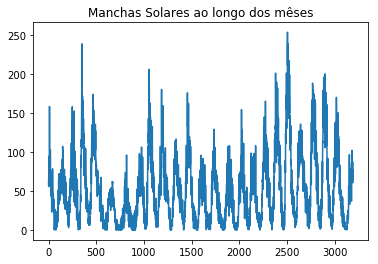

In [7]:
plt.plot(ss)
plt.title("Manchas Solares ao longo dos mêses")
plt.show()

### Parte A
Na parte A, deve-se utilizar K = 20 atrasos anteriores imediatos ao valor a ser previsto da série temporal como entradas (features) do modelo de Regressão Linear sem restrição, ou seja, sem regularização.

In [8]:
"""
args:
    arr: linear array of data
    K: number of features
return:
    Phi: Phi matrix for linear regressor calculus
"""

def Phi_matrix(arr, K):
    Phi = np.array([])
    for i in range(len(arr) - K + 1):
        Phi = np.append(Phi, 1)
        for j in range(K - 2, -1, -1):
            Phi = np.append(Phi, arr[i + j])
    Phi = Phi.reshape(int(Phi.shape[0] / K), K)
    return Phi

"""
args:
    size: identity matrix size minus 0's row an column
return:
    idm: identity matrix'
"""

def identity_matrix(size):
    idm = np.identity(size)
    idm = np.insert(idm, 0, 0, axis=1)
    idm = np.insert(idm, 0, 0, axis=0)
    
    return idm

"""
args:
    cols: number of columns 
    rows: number of rows
    rem_inx: index to be removed
return:
    a: boolean array with column drop(True) and column keep(False)
"""

def col_mask(cols, rem_inx):
    a = np.ones((cols), dtype=bool)
    for i in range (1, cols):
        if(i == rem_inx):
            a[i] = 0
    return a        
    
"""
args:
    cols: number of columns 
    rows: number of rows
    k: number of folders
    k_n: which folder 
return:
    a: boolean array with rows drop(False) and column keep(True)

"""    
def rows_mask(rows, cols, k, k_n):

    offset = int(rows/k)
    a = np.zeros((rows),dtype=bool)
    if(k != 1):
        for i in range(offset * k_n, offset * k_n + offset):
                a[i] = 1
    return a

"""
args:
    Phi: Phi matrix
    y: Labels
    lambdda: Ridge regression lambda
return:
    lin_reg: Linear Regression coefficients
"""
def pred_ridge(Phi, y, lambdda):
    
    identity = identity_matrix(Phi.shape[1] - 1)
    lin_reg = np.dot(np.dot( linalg.inv(np.dot(Phi.transpose(),Phi) + lambdda*identity), Phi.transpose()), y) 
    return lin_reg

#### Cross Validation
Divisão do conjunto de dados entre TREINO e TESTE. O conjunto de teste contém dados de 5 anos de observação. O treino é formado pelo restante dos dados.

In [9]:
TEST_SIZE = 12 * 5 # 12 months for 5 years
TRAIN_SIZE = ss.shape[0] - TEST_SIZE
K = 21 # num o variables + 1 (bias)

ss_train = ss[:TRAIN_SIZE]
ss_test = ss[TRAIN_SIZE - K + 1:] # Using training data to predict test data
y_train = ss[K-1:TRAIN_SIZE]
y_test = ss[TRAIN_SIZE:] # Will we use training data to predict test data ? Data leakage

assert y_test.shape[0] == TEST_SIZE, "Something went wrong with train/test split!"

Phi_tst = Phi_matrix(ss_test, K)
Phi = Phi_matrix(ss_train, K)

assert y_train.shape[0] == Phi.shape[0], "Matrix lenght does not match for multiplication!" 

#### Obtenção do Preditor Linear Ótimo
O preditor linear ótimo irrestrito é obtido através da fórmula fechada:
$$ \bf{W} = (\phi^{T}\phi)^{-1}\phi^{T}Y $$

In [10]:
Phi, y_train

(array([[   1. ,  103. ,   85.4, ...,   70. ,   62.6,   58. ],
        [   1. ,   91.2,  103. , ...,   55.7,   70. ,   62.6],
        [   1. ,   65.7,   91.2, ...,   85. ,   55.7,   70. ],
        ..., 
        [   1. ,    4.3,    0. , ...,    2.9,    9.3,    2.1],
        [   1. ,    4.8,    4.3, ...,    3.2,    2.9,    9.3],
        [   1. ,    4.1,    4.8, ...,    3.4,    3.2,    2.9]]),
 array([ 91.2,  65.7,  63.3, ...,   4.8,   4.1,  10.8]))

In [11]:
lin_reg = np.dot(np.dot(linalg.inv(np.dot(Phi.transpose(),Phi)), Phi.transpose() ), y_train) 
lin_reg

array([  3.40753279e+00,   5.42742346e-01,   9.36178958e-02,
         1.01431739e-01,   8.66568705e-02,   3.81649881e-02,
         6.33077050e-02,   8.09135445e-04,   2.78924119e-02,
         9.55003770e-02,   2.07517303e-02,   2.67433309e-02,
         5.34725403e-03,  -3.01700873e-02,   2.73501594e-02,
         1.32974778e-02,  -4.66236520e-02,  -5.55622599e-04,
        -7.26082436e-02,  -7.74804120e-03,  -5.20224438e-02])

#### Verificação do modelo
O parâmetro escolhido como métrica de qualidade do modelo é a o Root Mean Squared Error, ou RMSE. Que é dado da seguinte forma:
$$ \sqrt{\frac{1}{N}\Sigma(y - y')^{2}}$$

In [12]:
rmse = []
rmse.append(math.sqrt(np.mean(np.power(np.dot(Phi,lin_reg.T) - y_train, 2))))
rmse.append(math.sqrt(np.mean(np.power(np.dot(Phi_tst,lin_reg.T) - y_test, 2))))

print("Train RMSE: " + str(rmse[0]) + "\nTest RMSE: " +str(rmse[1])  )

Train RMSE: 15.370232088543426
Test RMSE: 14.249451112744604


#### Comentário
O modelo de Regressão Linear irrestrito construído obteve nos dados de treino RMSE = 15.37, enquanto que nos dados de teste obteve RMSE = 14.2494. É curioso obter o erro maior no conjunto utilizado para o treino em relação ao de teste. Como o nosso conjunto de teste é muito pequeno em relação ao conjunto de treino, de alguma forma pode ser que nosso conjunto de teste se encaixe de uma maneira melhor para o preditor linear que foi gerado, ocasionando em menor erro. Dessa forma, sugere-se que seja feita de fato uma seleção mais variada de dados de teste para que haja consistência na validação. A técnica de k-fold seria suficiente para confirmar a hipótese.

#### Comparação entre dados e predição
Abaixo está o gráfico que compara os dados gerados pelo modelo em comparação com os próprios dados do conjunto de teste.

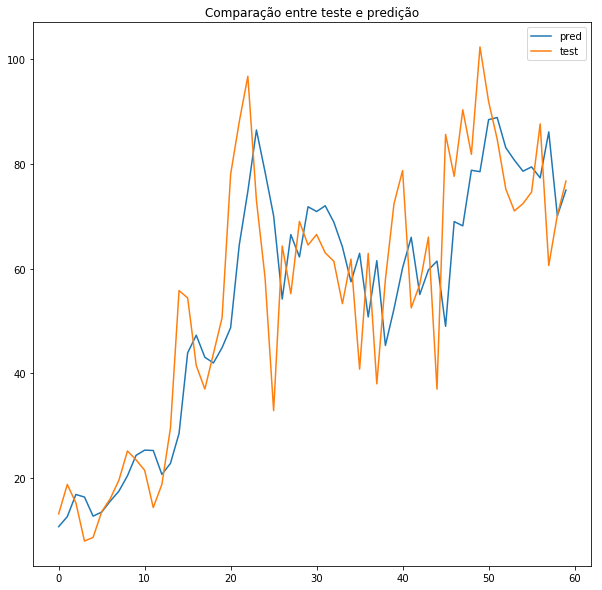

In [13]:
y_pred = np.dot(Phi_tst,lin_reg.T)
plt.figure(figsize=(10,10))
plt.plot(y_pred,label='pred')
plt.plot(y_test,label='test')
plt.legend()
plt.title("Comparação entre teste e predição")
plt.show()

#### Comentário

De acordo com o gráfico acima, podemos ver que o modelo de regressão linear utilizado como preditor da série temporal demonstra um comportamento semelhante ao dados de teste utilizados na validação do modelo. No entanto, pode-se notar  um leve atraso na predição. O modelo prevê melhor o valor do mês anterior.

### Parte B
A parte B tem o mesmo objetivo em vista, no entanto dessa vez serão introduzidos novos auxiliadores para a construção do modelo, dentre eles K-fold, Seleção de variáveis, e Regularização. 

#### Hiperparâmetros 

In [14]:
# Hyperparameters
Q_i = 21
Q_j = 20 # K + 1. Initial number of variables for Wrapper
lambdda = [ 1e-4, 1e-3, 1e-2, 1e-1, 0, 1e2, 1e3, 1e4, 1e5, 1e6, 1e8, 1e9] # Will name it lambdda instead of lambda for obvious reason
ss_b = ss
k = 13
drop = np.ones(20, dtype = bool)
# First Phi matrix
Phi = Phi_matrix(ss_b, Q_i)
y = ss[Q_i - 1:]

#### Treinamento do modelo
No treinamento do modelo será utilizado o `K-fold`, o qual faz a separação do conjunto de treinamento e teste em pastas. No nosso caso foram escolhidas `13` pastas por ser um número que divide os dados igualmente (sem resto) e facilitará na divisão das pastas.

Também é utilizada a técnica de seleção de variáveis denominada Wrapper com a abordagem de Backward Elimination, que consiste em ir, progressivamente, eliminando variáveis com o objetivo de diminur o erro, originando assim, um conjunto de variáveis que contém mais informação útil para previsão.

Por fim, também é utilizada a técnica de `regularização` L2, ou Ridge Regression para obter ainda menor erro de predição.

In [15]:
var_wrap = np.array([])
back_e_b = np.array([])
drop = []
best_lambda = []
a = 1
last_drop = -1
# Wrapper - Iteration of drops 
for q_i in range(Q_i,2,-1):
    back_e_a = np.array([])
    i_drop = 0
    cont = 1
    # Wrapper - Iterations of remaining variables    
    for q_j in range(Q_j,0,-1):
        
        rmse_list = []
        lambddas = []
        cm = col_mask(Phi.shape[1], cont)
        cont += 1
        # Regularization - Ridge Regression
        for f in range(len(lambdda)):

            #Refresh K-Fold parameters
            rmse = 0
            
            # K-fold
            for k_i in range(k):    
                rm = rows_mask(Phi.shape[0], Phi.shape[1] - 1, k, k_i)

                Phi_train = Phi[~rm]
                y_train = y[~rm]
                Phi_tst = Phi[rm]
                y_test = y[rm]
                
                Phi_train = Phi_train[:,cm]
                Phi_tst = Phi_tst[:,cm]

                # Obtain Linear Regressor predictor with train data 
                lin_reg = pred_ridge(Phi_train, y_train, lambdda[f])

                # RMSE metric of test set
                rmse += math.sqrt(np.mean(np.power(np.dot(Phi_tst, lin_reg.T) - y_test, 2)))

            rmse_list = np.append(rmse_list, rmse / k)
        
        i_lambda = np.unravel_index(np.argmin(rmse_list, axis=None), 
                                         rmse_list.shape)
        
        lambddas.append(lambdda[i_lambda[0]])
        back_e_a = np.append(back_e_a, np.amin(rmse_list))
    
    best_lambda.append(min(lambddas))
    var_wrap = np.append(var_wrap, np.amin(back_e_a))

    i_drop =  np.unravel_index(np.argmin(back_e_a, axis=None), 
                                         back_e_a.shape) # Wichever has the best lambda
    drop.append(i_drop[0])
    Phi = np.delete(Phi, i_drop[0] + 1, axis=1)
    Q_j -= 1

O melhor lambda de regularização para cada retirada de variável segue abaixo:

In [16]:
best_lambda

[10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 1000.0,
 0]

Após treinamento deve-se verificar qual o número de variáveis retiradas pelo Wrapper torna o preditor mais eficaz.

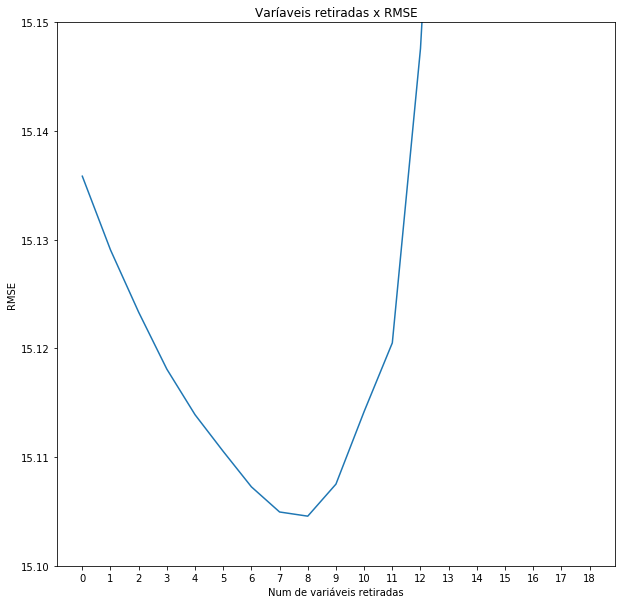

In [17]:
plt.figure(figsize=(10,10))
plt.title("Varíaveis retiradas x RMSE")
plt.ylabel("RMSE")
plt.xlabel("Num de variáveis retiradas")
plt.ylim(15.1,15.150)
plt.xticks(np.arange(20))
plt.plot(var_wrap)
plt.show()

O gráfico acima nos mostra que o erro se torna menor ao retirarmos **8** variáveis. Sendo assim, **12** é quantidade de variáveis que forma o conjunto "ótimo" para o modelo proposto. Em seguida está a definição de quais são especificamente essas features.

In [18]:
var_list = np.arange(0,20)
print("Sequência de retirada de variáveis para melhorar o modelo:")
for i in (drop):
    print(var_list[i]) # Since first column of bias is not represented here, we should shift right
    var_list = np.delete(var_list, i, axis=0)

Sequência de retirada de variáveis para melhorar o modelo:
12
11
16
9
14
18
6
13
7
4
15
10
19
5
2
1
17
8
3


#### Comentário
De acordo com a sequência obtida acima, as variáveis do conjunto ótimo estão dispostas na tabela abaixo. Como a variável de Bias não foi retirada em nenhum momento, por motivos de design do projeto (notadamente essa variável possuía influência maior que as outras), foi feito um shift para a direita com as nossas features.

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
|---|---|---|---|---|---|---|---|---|---|----|----|----|----|----|----|----|----|----|----|----|
| x | x | x | x | x | x | x | o | x | x | o  | x  | o  | o  | o  | o  | x  | o  | x  | o  | x  |

### Parte C
Outra abordagem para a seleção de variáveis é a aplicação de Filtro. Deve-se utilizar alguma métrica para escolher quais variáveis são mais importantes e influenciam no modelo. Sendo assim, será usada a Correlação linear (Pearson).

In [19]:
def centering(y):
    
    y_mean = np.mean(y)
    y_cen = y - y_mean
    y_cen = y_cen.reshape(y_cen.shape[0], 1)
    return y_cen

def correlation(var, y):
    
    # Center var after mean
    corr = np.sum(np.multiply(var, y)) /np.sqrt(np.sum(var ** 2) * np.sum(y ** 2))
    return corr

In [20]:
Q_i = 21 # Features
k = 26 # k-fold
Phi = Phi_matrix(ss_b, Q_i)
y = ss[Q_i - 1:]
lambdda = [ 1e-4, 1e-3, 1e-2, 1e-1, 0, 1e2, 1e3, 1e4, 1e5, 1e6, 1e8, 1e9]
corr = []
rmse_list = np.array([])

y_cent = centering(y) # Center array Y befor for loop. No need to do this inside the loop.


for q_j in range(1, Q_i):
    
    cm = col_mask(Phi.shape[1], q_j)  
    var = Phi[:,~cm] # Vary column to be tested.
    var_centered = centering(var)
    
    corr.append(correlation(y_cent, var_centered))
    
    

Abaixo segue a correlação entre as variáveis de entrada e a saída observada. A sequência está ordenada da variável mais recente para a mais antiga.

In [21]:
corr

[0.9239307587138349,
 0.89341979069899036,
 0.87861310869312692,
 0.866970890645401,
 0.85293344763363343,
 0.84057803603157977,
 0.823016265694689,
 0.80947132546839107,
 0.79952745506653111,
 0.78027719801169826,
 0.7595273154549721,
 0.73598850756996814,
 0.71048216169210332,
 0.68896660131133791,
 0.66375663892859771,
 0.6322868248197544,
 0.60383900185503969,
 0.5712131825406459,
 0.54401103728234412,
 0.5139080207178468]

Máscara de features a serem utilizadas na correlação.

In [22]:
corr = np.array([True if (i > 0.72) else False for i in (corr)])# To keep it with 12 variables. 
corr = np.append(corr, False)    #Add 1 in len for Bias
corr

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [23]:
# Regularization - Ridge Regression
for f in range(len(lambdda)):

    #Refresh K-Fold parameters
    rmse = 0
    for k_i in range(k):    
        rm = rows_mask(Phi.shape[0], Phi.shape[1] - 1, k, k_i)

        Phi_train = Phi[~rm]
        y_train = y[~rm]
        Phi_tst = Phi[rm]
        y_test = y[rm]

        Phi_train = Phi_train[:,corr]
        Phi_tst = Phi_tst[:,corr]

        # Obtain Linear Regressor predictor with train data 
        lin_reg = pred_ridge(Phi_train, y_train, lambdda[f])

        # RMSE metric of test set
        rmse += math.sqrt(np.mean(np.power(np.dot(Phi_tst, lin_reg.T) - y_test, 2)))
    
    rmse_list = np.append(rmse_list, rmse / k)
    i_lambda = np.unravel_index(np.argmin(rmse_list, axis=None), 
                                         rmse_list.shape)
        
lambddas = lambdda[i_lambda[0]]


Abaixo está o hiperparâmetro Lambda da regularização que melhor se aplica à abordagem de filtro.

In [24]:
lambddas

10000.0

#### Comentário
A correlação de Pearson indicou que os dados mais recentes são aqueles que possuem mais correlação com a observação de saída. Percebe-se que esse método de seleção de variáveis não vai ao encontro do Wrapper com Backward Elimination realizado no item anterior. No entanto, nada indica com clareza qual o erro presente na abordagem do filtro.